In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import random
import timeit
from scipy.spatial import distance as dst
import itertools
import pickle
import scipy.stats as stats

name_list = ['human_neuron','rat_neuron',
            'monkey_neuron','zebrafish_neuron','fruit_fly_2','fruit_fly_3','fruit_fly_1','fruit_fly_4',
    'vascular_2','vascular_3','vascular_1','mitochondrial','anthill','root_1','root_2'] #,tree
ordered_name_list = [
    "h_neuron",
    "r_neuron",
    "m_neuron",
    "z_neuron",
    "anthill",
    "root_1",
    "root_2",
    "fruit_fly_1",
    "fruit_fly_2",
    "fruit_fly_3",
    "fruit_fly_4",
    "vascular_1",
    "vascular_2",
    "vascular_3",
    "mitochon"
]
color_dict = {'root_1':'green','root_2':'olive','mitochondrial':'y','vascular_1':'red','vascular_2':'crimson','vascular_3':'salmon',
              'fruit_fly_2':'purple','fruit_fly_3':'pink','tree':'brown','rat_neuron':'lightblue','human_neuron':'blue',
              'anthill':'silver','fruit_fly_1':'deeppink','fruit_fly_4':'plum','zebrafish_neuron':'cyan','monkey_neuron':'teal'}
category_color_dict = {'root_1':'green','root_2':'green','mitochondrial':'blue','vascular_1':'b','vascular_2':'blue','vascular_3':'blue',
              'fruit_fly_2':'red','fruit_fly_3':'red','tree':'green','rat_neuron':'green','human_neuron':'green',
              'anthill':'green','fruit_fly_1':'red','fruit_fly_4':'red','zebrafish_neuron':'green','monkey_neuron':'green'}
name_change_dict = {'mitochondrial':'mitochon','human_neuron':'h_neuron','monkey_neuron':'m_neuron','rat_neuron':'r_neuron','zebrafish_neuron':'z_neuron'}
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 

def compute_iqr(x):
    q75, q25 = np.percentile(x, [75 ,25])
    iqr = q75 - q25
    return iqr

In [108]:
path_source = '0. link_properties/'
path = '../1. data/3. final_data/'
    
all_results = {}
for name in name_list:
    infile = open(path_source + name +'_basic_results.pkl','rb')
    all_results[name] = pickle.load(infile)
    aspect_ratio_list = []
    for i in range(0,len(all_results[name]['segment_length_list'])):
        aspect_ratio_list.append(all_results[name]['radius_list'][i]/all_results[name]['segment_length_list'][i])
    path = '../1. data/3. final_data/'
    
    # Load and preprocess skeleton paths data
    skeleton_paths = pd.read_csv(path + name + '.paths.csv', index_col=[0])
    all_results[name]['segment_aspect_ratio_list'] = aspect_ratio_list[:]
    all_results[name]['median_segment_aspect_ratio'] = np.round(np.median(aspect_ratio_list[:]),2)
    all_results[name]['iqr_segment_aspect_ratio'] = np.round(compute_iqr(aspect_ratio_list[:]),2)
    all_results[name]['total_number_of_segments'] = len(skeleton_paths)
    all_results[name]['total_number_of_links'] = len(skeleton_paths['path_id'].unique())
    all_results[name]['total_number_of_nodes'] = len(set(list(skeleton_paths['source'].unique()) + list(skeleton_paths['target'].unique())))

In [127]:
all_results[name]['radius_list']

array([98.2346906 , 92.91237332, 85.86702694, ...,  4.47481753,
        5.70890076,  6.94298398])

In [125]:
data = {}
data['dataset'] = []
data['segment_length'] = []
data['segment_radius'] = []
data['segment_aspect_ratio'] = []
data['total_number_of_segments'] = []
data['total_number_of_links'] = []
data['total_number_of_nodes'] = []

for name in all_results.keys():
    if name in name_change_dict.keys():
        label_name = name_change_dict[name]
    else:
        label_name = name
    data['dataset'].append(label_name)
    data['segment_length'].append(str(np.round(np.median(all_results[name]['segment_length_list']),2)) + ' \u00B1 ' + str(np.round(compute_iqr(all_results[name]['segment_length_list']),2)))
    data['segment_radius'].append(str(np.round(np.median(all_results[name]['radius_list']),2)) + ' \u00B1 ' + str(np.round(compute_iqr(all_results[name]['radius_list']),2)))
    data['segment_aspect_ratio'].append(str(np.round(all_results[name]['median_segment_aspect_ratio'],2)) + ' \u00B1 ' + str(np.round(all_results[name]['iqr_segment_aspect_ratio'],2)))
    data['total_number_of_segments'].append(all_results[name]['total_number_of_segments'])
    data['total_number_of_links'].append(all_results[name]['total_number_of_links'])
    data['total_number_of_nodes'].append(all_results[name]['total_number_of_nodes'])
df_data = pd.DataFrame(data)
df_data.sort_values(by=['total_number_of_segments'],inplace=True)
df_data

,dataset,segment_length,segment_radius,segment_aspect_ratio,total_number_of_segments,total_number_of_links,total_number_of_nodes
11,mitochon,0.09 ± 0.06,0.11 ± 0.02,1.17 ± 0.67,847,73,59
14,root_2,38.49 ± 12.56,7.2 ± 7.47,0.18 ± 0.2,2132,410,411
3,z_neuron,1.51 ± 1.24,0.34 ± 0.12,0.22 ± 0.19,2867,307,308
1,r_neuron,2.21 ± 1.98,0.46 ± 0.19,0.22 ± 0.27,4536,185,186
13,root_1,25.65 ± 0.61,4.7 ± 5.11,0.18 ± 0.2,5619,983,984
9,vascular_3,5.1 ± 1.95,2.96 ± 0.97,0.61 ± 0.31,12487,1181,789
8,vascular_2,3.91 ± 1.11,3.17 ± 1.41,0.83 ± 0.45,16078,1300,862
2,m_neuron,0.36 ± 0.28,0.23 ± 0.15,0.62 ± 0.3,16814,154,155
10,vascular_1,4.69 ± 1.62,3.0 ± 1.22,0.62 ± 0.33,17935,2359,1558
12,anthill,16.4 ± 8.43,9.6 ± 3.18,0.59 ± 0.3,29541,15564,15565


## Number of skeleton segments 

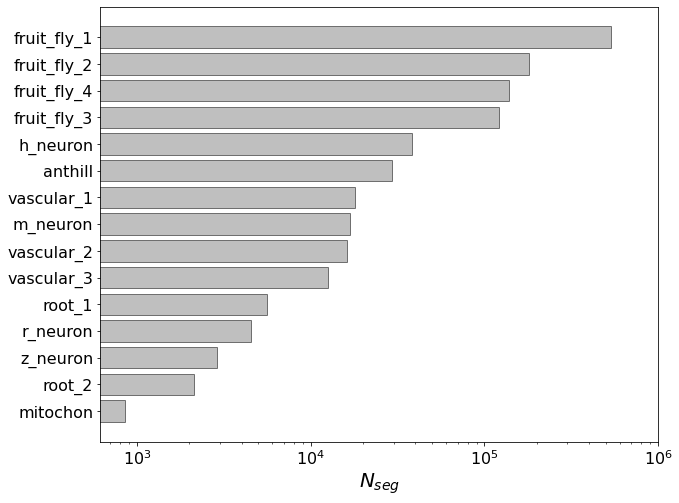

In [128]:
plt.figure(figsize=(10,8))
df_sorted = df_data.sort_values(by='total_number_of_segments', ascending=True)
plt.barh(df_sorted['dataset'],df_sorted['total_number_of_segments'],alpha=0.5,edgecolor='black',orientation='horizontal',color='gray')
plt.xscale('log')
plt.xticks([1000,10000,100000,1000000])
plt.xlabel(r'$N_{seg}$',fontsize=20)
plt.savefig('nr_segment_distribution.pdf', format='pdf',dpi=1200)